<a href="https://colab.research.google.com/github/sayakpaul/GAN-Hacks/blob/master/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
!wget https://gist.githubusercontent.com/sayakpaul/1e0f3ae671b62413d9ee98626a71f23d/raw/31df245ab4476db32563f6b86e3a22890df6e487/download_cyclegan_data.sh

In [3]:
!sh download_cyclegan_data.sh monet2photo

download_cyclegan_data.sh: 5: download_cyclegan_data.sh: [[: not found
for details.

--2020-03-25 10:00:02--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305231073 (291M) [application/zip]
Saving to: ‘/content/monet2photo.zip’

/content/monet2phot 100%[===================>] 291.09M  21.5MB/s    in 14s     

2020-03-25 10:00:18 (20.4 MB/s) - ‘/content/monet2photo.zip’ saved [305231073/305231073]



In [4]:
!ls monet2photo/

testA  testB  trainA  trainB


## Reference: Machine Learning Mastery's book on GANs

In [0]:
# example of preparing the horses and zebra dataset
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from os import listdir
import numpy as np
from tqdm import tqdm

In [0]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
    data_list = list()
    
    # enumerate filenames in directory, assume all are images
    for filename in tqdm(listdir(path)):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store
        data_list.append(pixels)
    
    return np.array(data_list)

In [4]:
# dataset path
path = "monet2photo/"

# load dataset A
dataA1 = load_images(path + "trainA/") 
dataA2 = load_images(path + "testA/") 
dataA = np.concatenate([dataA1, dataA2])
print("Loaded dataA: ", dataA.shape)

# load dataset B
dataB1 = load_images(path + "trainB/") 
dataB2 = load_images(path + "testB/") 
dataB = np.concatenate([dataB1, dataB2])
print("Loaded dataB: ", dataB.shape)

  1%|          | 54/6287 [00:00<00:11, 534.76it/s]

Loaded dataA:  (1193, 256, 256, 3)


100%|██████████| 751/751 [00:01<00:00, 562.91it/s]


Loaded dataB:  (7038, 256, 256, 3)


In [0]:
import matplotlib.pyplot as plt

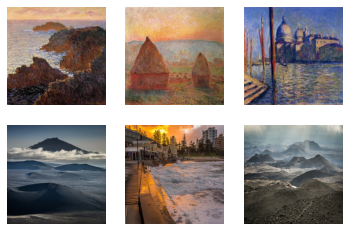

In [6]:
n_samples = 3

# plot source images
for i in range(n_samples): 
    plt.subplot(2, n_samples, 1 + i) 
    plt.axis("off") 
    plt.imshow(dataA[i].astype("int"))
 
# plot target image
for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + n_samples + i) 
    plt.axis("off") 
    plt.imshow(dataB[i].astype("int"))   

In [0]:
# needed for instance normalization
!pip install -q  --no-deps tensorflow-addons~=0.7

In [0]:
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa

In [0]:
# define the discriminator model
def define_discriminator(image_shape):
    # source image input
    in_image = Input(shape=image_shape)

    # init
    init = RandomNormal(stddev=0.02)
    
    # C64
    d = Conv2D(64, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)

    # C128
    d = Conv2D(128, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C256
    d = Conv2D(256, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)
    
    # C512
    d = Conv2D(512, (4,4), strides=(2,2), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # second last output layer
    d = Conv2D(512, (4,4), padding="same", kernel_initializer=init)(d) 
    d = tfa.layers.InstanceNormalization(axis=3)(d)
    d = LeakyReLU(alpha=0.2)(d)

    # patch output
    patch_out = Conv2D(1, (4,4), padding="same", kernel_initializer=init)(d) 
    
    # define model
    model = Model(in_image, patch_out)
    
    return model 

In [0]:
# generator a resnet block
def resnet_block(n_filters, input_layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # first layer convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(input_layer) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    g = Activation("relu")(g)
    
    # second convolutional layer
    g = Conv2D(n_filters, (3,3), padding="same", kernel_initializer=init)(g) 
    g = tfa.layers.InstanceNormalization(axis=3)(g)
    
    # concatenate merge channel-wise with input layer
    g = Concatenate()([g, input_layer])
    
    return g

In [0]:
# define the standalone generator model
def define_generator(image_shape=(256,256,3), n_resnet=3):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)

	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)

	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	g = Activation('relu')(g)

	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = tfa.layers.InstanceNormalization(axis=3)(g)
	out_image = Activation('tanh')(g)

	# define model
	model = Model(in_image, out_image)

	return model

In [11]:
# discriminator
discriminator = define_discriminator((256,256,3))
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization (Inst (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       524544

In [12]:
# generator
generator = define_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_4 (Insta (None, 256, 256, 64) 128         conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           instance_normalization_4[0][0]   
____________________________________________________________________________________________

In [0]:
# input shape
image_shape = (256,256,3)

# generator: A -> B
g_model_AtoB = define_generator(image_shape, n_resnet=6)
# generator: B -> A
g_model_BtoA = define_generator(image_shape, n_resnet=6)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

In [0]:
import tensorflow as tf

In [0]:
def real_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "real"?
    # label for real is 1
    ones = tf.ones_like(len(D_out), dtype=tf.float32)
    return mse(D_out, ones)

def fake_mse_loss(D_out):
    mse = tf.keras.losses.MeanSquaredError()
    # how close is the produced output from being "fake"?
    # label for fake is 0
    zeros = tf.zeros_like(len(D_out), dtype=tf.float32)
    return mse(D_out, zeros)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    mae = tf.keras.losses.MeanAbsoluteError()
    # calculate reconstruction loss 
    # as absolute value difference between the real and reconstructed images
    reconstr_loss = mae(real_im, reconstructed_im)
    # return weighted loss
    return lambda_weight*reconstr_loss 

In [0]:
# these values come from the original paper
###########################################

# hyperparams for Adam optimizer
lr=0.0002
beta1=0.5
beta2=0.999 # default value

# create optimizers for the generators and discriminators
g_AtoB_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
g_BtoA_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_A_opt = Adam(lr, beta_1=beta1, beta_2=beta2)
d_model_B_opt = Adam(lr, beta_1=beta1, beta_2=beta2)

In [0]:
@tf.function
def train_discriminator_A(dA, gBA, images_B, images_A, d_model_A_opt):
    with tf.GradientTape() as tape:
        # discriminator A
        dA_real_logits = dA(images_A)
        dA_real_loss = real_mse_loss(dA_real_logits)

        # discriminator A on fake stuff
        fake_A = gBA(images_B)
        dA_fake_logits = dA(fake_A)
        dA_fake_loss = fake_mse_loss(dA_fake_logits)

        # total dA loss
        total_dA_loss = dA_real_loss + dA_fake_loss

    # compute gradients and backprop
    dA_grads = tape.gradient(total_dA_loss, dA.trainable_variables)
    d_model_A_opt.apply_gradients(zip(dA_grads, dA.trainable_variables))

    return total_dA_loss

@tf.function
def train_discriminator_B(dB, gAB, images_A, images_B, d_model_B_opt):
    with tf.GradientTape() as tape:
        # discriminator B
        dB_real_logits = dB(images_B)
        dB_real_loss = real_mse_loss(dB_real_logits)

        # discriminator B on fake stuff
        fake_B = gAB(images_A)
        dB_fake_logits = dB(fake_B)
        dB_fake_loss = fake_mse_loss(dB_fake_logits)

        # total dA loss
        total_dB_loss = dB_real_loss + dB_fake_loss

    # compute gradients and backprop
    dB_grads = tape.gradient(total_dB_loss, dB.trainable_variables)
    d_model_B_opt.apply_gradients(zip(dB_grads, dB.trainable_variables))

    return total_dB_loss

In [0]:
sample_Images_A = dataA[32].reshape(1, 256, 256, 3)
sample_Images_B = dataB[32].reshape(1, 256, 256, 3)

In [34]:
print(train_discriminator_A(d_model_A, g_model_BtoA, sample_Images_B, sample_Images_A, d_model_A_opt))

tf.Tensor(10.23643, shape=(), dtype=float32)
